In [1]:
from plantcv import plantcv as pcv
from plantcv.parallel import WorkflowInputs
import matplotlib.pyplot as plt
import os 
from tqdm import tqdm
from pprint import pprint
print(os.getcwd())
image_dir = "/work/growth_chamber/images"
mask_dir = "/work/growth_chamber/v2_segmentations"

/


In [2]:
import glob
# Define the naming scheme
naming_scheme = os.path.join(image_dir, "topview_*.jpg")
# Get all file names that match the naming scheme
image_filenames = glob.glob(naming_scheme)

print(len(image_filenames))       


856


In [3]:
# Input/output options
args = WorkflowInputs(
    images=image_filenames,    
    names='test',
    result="topview_results",
    outdir=".",
    writeimg=False,
    # debug="plot",
    sample_label="plant"
    )
# Set debug to the global parameter 
pcv.params.debug = args.debug
# Set plotting size (default = 100)
pcv.params.dpi = 200
# Increase text size and thickness to make labels clearer
# (size may need to be altered based on original image size)
pcv.params.text_size = 10
pcv.params.text_thickness = 20

In [4]:
for file in tqdm(image_filenames):
    base_name = file.split('/')[-1].split('.')[0]
    img, path, filename = pcv.readimage(filename=file)
    mask_filename = os.path.join(mask_dir, base_name)
    # print(len(glob.glob(f"{mask_filename}_*.jpg")))
    for mask_file in glob.glob(f"{mask_filename}_*.jpg"):
        # print(f"Processing {file} with mask {mask_file}")
        mask, mask_path, mask_filename = pcv.readimage(filename=mask_file)
        plant_id = mask_filename.split('/')[-1].split('.')[0].split('_')[-1]
        # print(f"{base_name}_plant{plant_id}")
        shape_img = pcv.analyze.size(
            img=img, 
            labeled_mask=mask,
            label= f"{base_name}_{plant_id}",
            n_labels=1)
        # colo_img = pcv.analyze.color(rgb_img=img,
        #     labeled_mask=mask,
        #     n_labels=1,
        #     label= f"{base_name}_{plant_id}", 
        #     colorspaces="HSV"
        #     )
pcv.outputs.save_results(filename='/work/growth_chamber/pcv_output.json')

100%|███████████████████████████████████████████████████████| 856/856 [37:42<00:00,  2.64s/it]


In [5]:
import pandas as pd 
import re 
rows = []
for i in pcv.outputs.observations.keys():
    match = re.search(r"topview_(\d{4}-\d{2}-\d{2}_\d{2}_\d{2}_\d{2})", i)
    time_stamp = match.group(1)
    plant_id = i.split('_')[-2]
    # print(time_stamp,plant_id)
    obs_data = {k: v["value"] for k, v in pcv.outputs.observations[i].items()}
    # Convert to datetime
    rows.append({
        "timestamp" : pd.to_datetime(time_stamp, format="%Y-%m-%d_%H_%M_%S"),
        "plant_id": plant_id,
        **obs_data 
    })

df = pd.DataFrame(rows)
pprint(df.head())


df.to_csv('/work/growth_chamber/pcv_data_frame.csv')                                                    

            timestamp plant_id  in_bounds    area  convex_hull_area  solidity  \
0 2024-08-06 11:15:01        8       True  1405.0          182741.5  0.007688   
1 2024-08-06 11:15:01        9       True  1799.0          239785.5  0.007503   
2 2024-08-06 11:15:01        3       True  2134.0          286871.5  0.007439   
3 2024-08-06 11:15:01       13       True  1859.0          147937.0  0.012566   
4 2024-08-06 11:15:01        1      False  2122.0          277285.5  0.007653   

       perimeter  width  height  longest_path  \
0   85556.673603    528     480    548.639226   
1  114459.787256    655     600    627.034289   
2  145846.558862    704     656    671.607772   
3  101149.177242    512     456    527.784994   
4  162764.797185    672     568    640.415490   

                             center_of_mass  convex_hull_vertices  \
0  (1857.2868327402134, 1321.9039145907473)                    17   
1  (1877.5869927737633, 1823.0155642023346)                    23   
2    (950.9

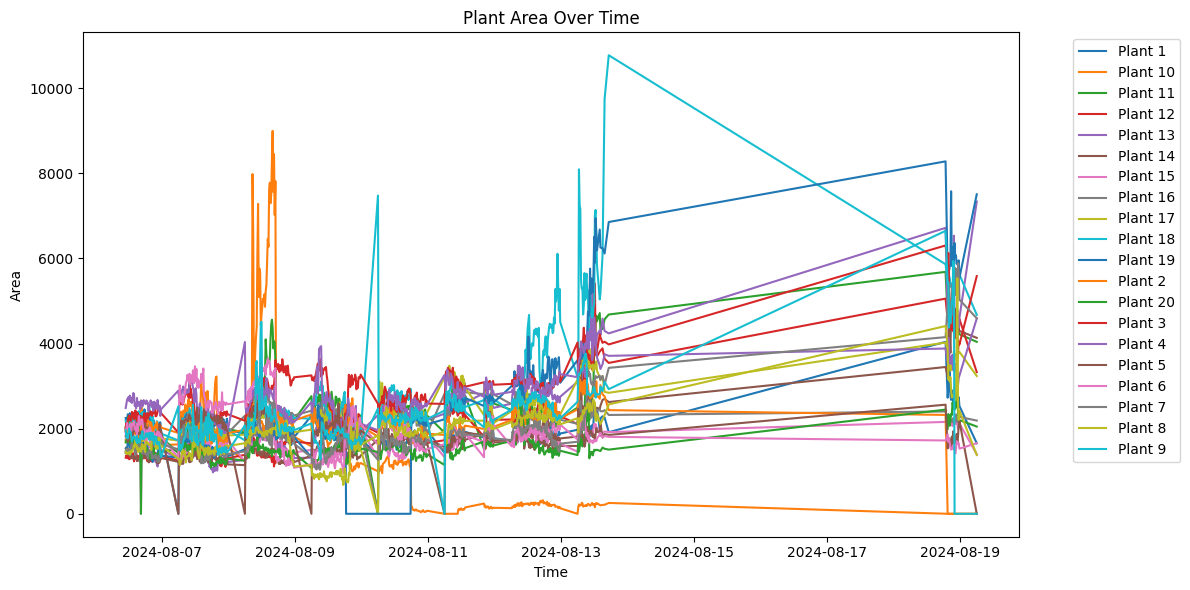

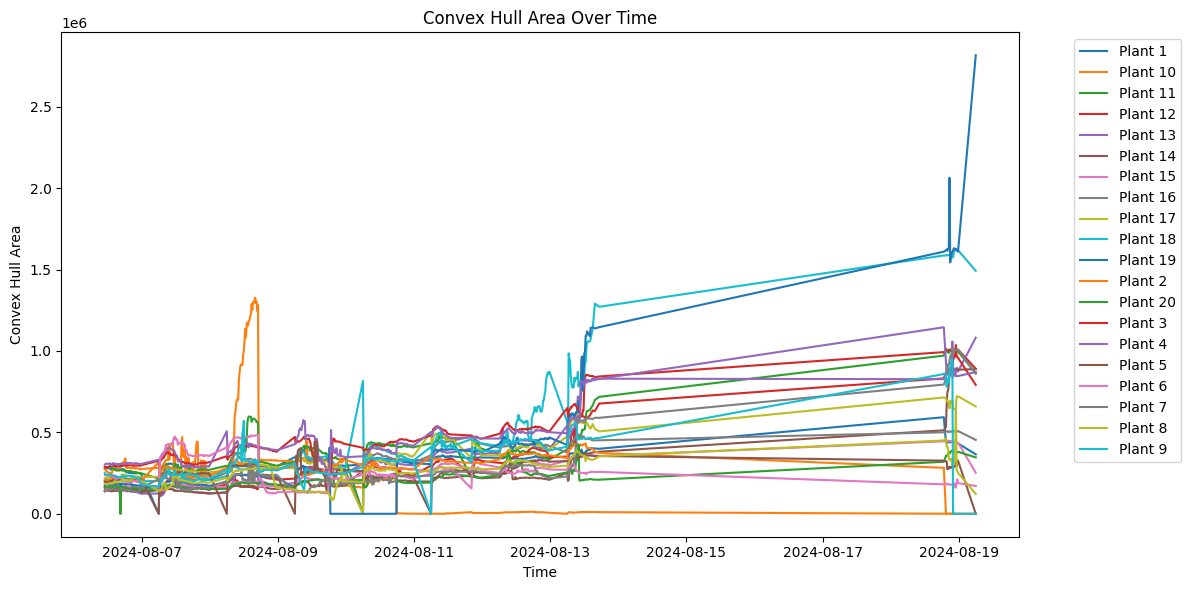

In [6]:
import matplotlib.pyplot as plt

# Make sure timestamp column is datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Sort by plant and time (just in case)
df = df.sort_values(["plant_id", "timestamp"])

# Plot area over time for each plant
plt.figure(figsize=(12,6))
for plant_id, group in df.groupby("plant_id"):
    plt.plot(group["timestamp"], group["area"], label=f"Plant {plant_id}")
plt.xlabel("Time")
plt.ylabel("Area")
plt.title("Plant Area Over Time")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Plot convex_hull_area over time for each plant
plt.figure(figsize=(12,6))
for plant_id, group in df.groupby("plant_id"):
    plt.plot(group["timestamp"], group["convex_hull_area"], label=f"Plant {plant_id}")
plt.xlabel("Time")
plt.ylabel("Convex Hull Area")
plt.title("Convex Hull Area Over Time")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


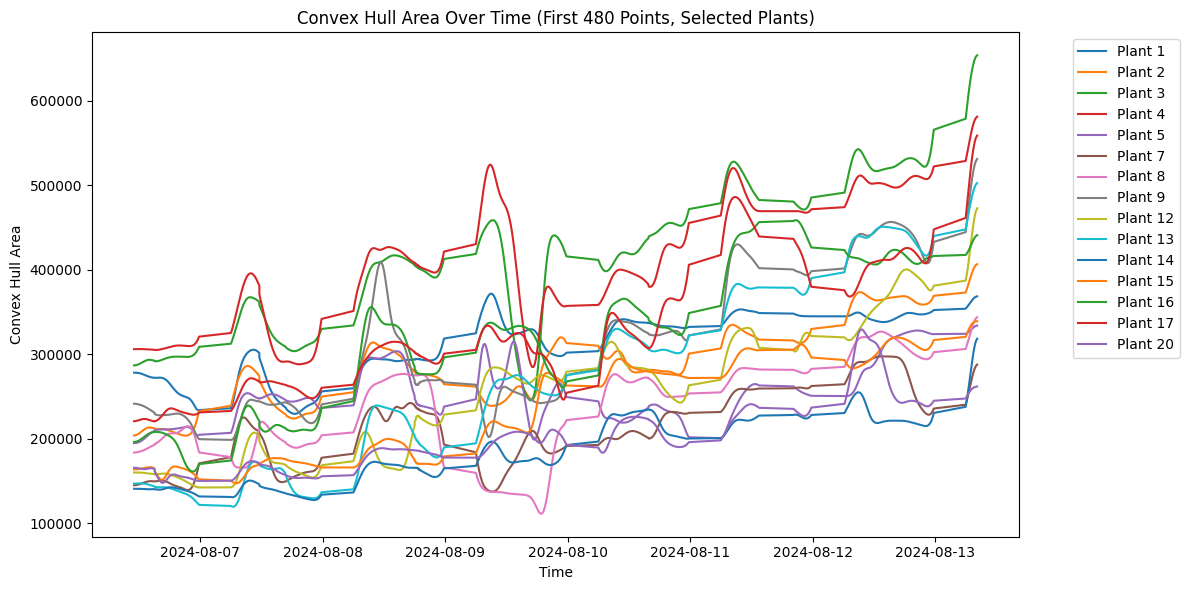

In [27]:
from scipy.ndimage import gaussian_filter1d
# Exclude unwanted plants
# exclude_plants = { 4, 6, 7, 10,12, 17,18, 19}
exclude_plants = {6,10,11,18,19}
df["plant_id"] = df["plant_id"].astype(int)
df_filtered = df[~df["plant_id"].isin(exclude_plants)]

# Keep only the first 480 time points overall
df_filtered = (
    df_filtered.sort_values("timestamp")
    .groupby("plant_id")
    .head(480)
)



# Plot convex_hull_area over time
plt.figure(figsize=(12,6))
for plant_id, group in df_filtered.groupby("plant_id"):
    smoothed = gaussian_filter1d(group["convex_hull_area"].values, sigma=4)
    df_filtered.loc[group.index, "convex_hull_area_smoothed"] = smoothed
    plt.plot(group["timestamp"], smoothed, label=f"Plant {plant_id}")

plt.xlabel("Time")
plt.ylabel("Convex Hull Area")
plt.title("Convex Hull Area Over Time (First 480 Points, Selected Plants)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

### Extracting Growth rates 
**Absolute Growth Rate (AGR)**  
	   - Measures the raw increase in the trait per unit time.  
	   - Formula: $$AGR(t_j,t_k)=\frac{PSA_{t_k}-PSA_{t_j}}{t_k-t_j}$$  
	   - Units: same as PSA per unit time (e.g., area/day).  
	   - Example: If PSA increases from 100 → 130 between Day 10 and Day 11:  
	     $$AGR=\frac{130-100}{1}=30$$
	
**Relative Growth Rate (RGR)**  
	   - Measures proportional increase relative to plant size.  
	   - Formula: $$RGR(t_j,t_k)=\frac{\ln(PSA_{t_k})-\ln(PSA_{t_j})}{t_k-t_j}$$  
	   - Units: per unit time (e.g., per day).  
	   - Example: If PSA increases from 100 → 130 between Day 10 and Day 11:  
	     $$RGR=\frac{\ln(130)-\ln(100)}{1}\approx0.262\ \text{day}^{-1}$$
	
**Why use both?**  
	   - **AGR** shows the absolute gain in biomass/area per day.  
	   - **RGR** shows growth efficiency, accounting for starting size.  
	   - Smaller plants can have lower AGR but higher RGR.

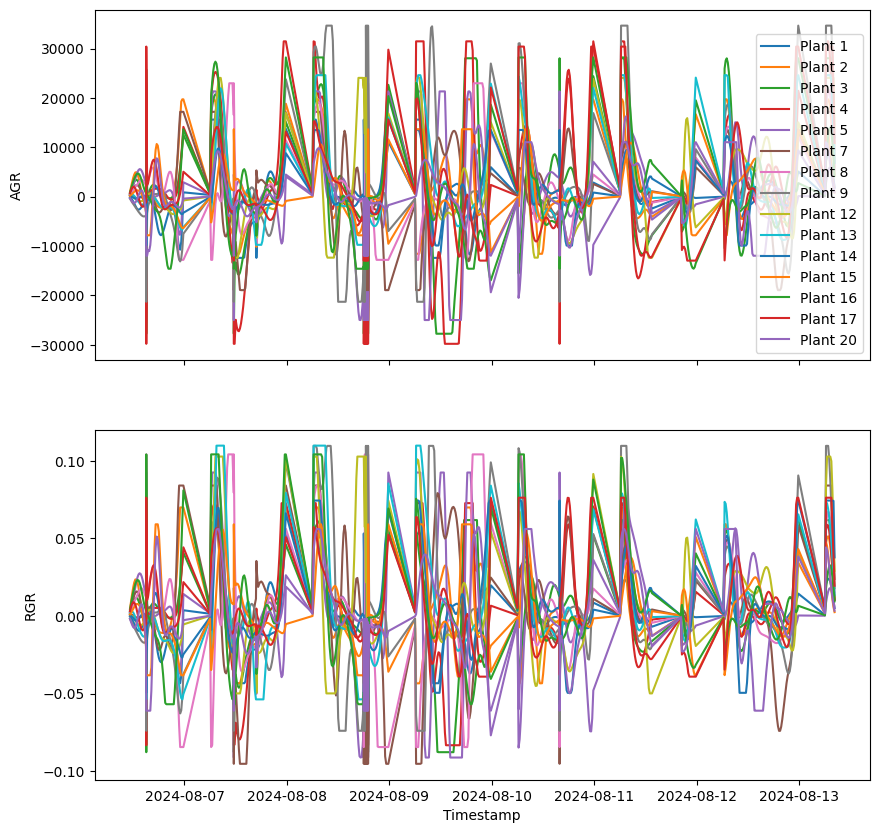

In [28]:
import numpy as np
grp = df_filtered.groupby("plant_id")

# ΔA
dA = grp["convex_hull_area_smoothed"].diff()

# Δt in hours
dt_hr = grp["timestamp"].diff().dt.total_seconds() / 3600

# compute log(A) properly on the raw Series
logA = np.log(df_filtered["convex_hull_area_smoothed"])

# Δlog(A), grouped shift
dlnA = logA - grp["convex_hull_area_smoothed"].shift(1).pipe(np.log)

df_filtered["RGR"] = dlnA / dt_hr
df_filtered["AGR"] = dA / dt_hr

# Create output columns
df_filtered["AGR_clipped"] = np.nan
df_filtered["RGR_clipped"] = np.nan

for pid, group in df_filtered.groupby("plant_id"):
    # AGR clipping thresholds
    agr_low = group["AGR"].quantile(0.05)
    agr_high = group["AGR"].quantile(0.95)

    # RGR clipping thresholds
    rgr_low = group["RGR"].quantile(0.05)
    rgr_high = group["RGR"].quantile(0.95)

    # Apply clipping back to the original dataframe
    df_filtered.loc[group.index, "AGR_clipped"] = group["AGR"].clip(agr_low, agr_high)
    df_filtered.loc[group.index, "RGR_clipped"] = group["RGR"].clip(rgr_low, rgr_high)



fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
for pid, group in df_filtered.groupby("plant_id"):
    ax[0].plot(group["timestamp"], group["AGR_clipped"], label=f"Plant {pid}")
ax[0].set_ylabel("AGR")
ax[0].legend()

# RGR
for pid, group in df_filtered.groupby("plant_id"):
    ax[1].plot(group["timestamp"], group["RGR_clipped"], label=f"Plant {pid}")
ax[1].set_ylabel("RGR")
ax[1].set_xlabel("Timestamp")

plt.show()

In [29]:
import statsmodels.formula.api as smf
channel_mapping = {
    1: 1, 2: 1, 3: 1, 4: 1, 5: 1,
    6: 2, 7: 2, 8: 2, 9: 2, 10: 2,
    11: 3, 12: 3, 13: 3, 14: 3, 15: 3,
    16: 4, 17: 4, 18: 4, 19: 4, 20: 4
}

df_filtered = df_filtered[df_filtered["convex_hull_area_smoothed"] > 0]
df_filtered["treatment"] = df_filtered["plant_id"].map(channel_mapping)
frequency_map = {1: 0, 2: 0, 3: 1, 4: 1} # 0 = low, 1 = high
volume_map = {1: 1, 2: 0, 3: 0, 4: 1}    # 0 = low, 1 = high
df_filtered["irrigation_frequency"] = df_filtered["treatment"].map(frequency_map)
df_filtered["irrigation_volume"] = df_filtered["treatment"].map(volume_map)
df_filtered["log_area"] = np.log(df_filtered["convex_hull_area_smoothed"])
df_filtered["DAP"] = (
    df_filtered["timestamp"] - df_filtered["timestamp"].min()
).dt.total_seconds() / (3600 * 24)
# # Until we can get valid samples for all treatments, we can't run the full model that includes the 2x2 design
model = smf.mixedlm("log_area ~ DAP * C(irrigation_frequency) * C(irrigation_volume)", 
                    df_filtered,
                    groups=df_filtered["plant_id"],
                    re_formula="~1")
# This model uses treatment as a single factor instead of the 2x2 design, you just have to interpret it accordingly
# model = smf.mixedlm("log_area ~ DAP * C(treatment)", 
#                     df_filtered,
#                     groups=df_filtered["plant_id"],
#                     re_formula="~1")

result = model.fit()
print(result.summary())


                                Mixed Linear Model Regression Results
Model:                             MixedLM                Dependent Variable:                log_area 
No. Observations:                  7200                   Method:                            REML     
No. Groups:                        15                     Scale:                             0.0161   
Min. group size:                   480                    Log-Likelihood:                    4581.8075
Max. group size:                   480                    Converged:                         Yes      
Mean group size:                   480.0                                                              
------------------------------------------------------------------------------------------------------
                                                           Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------------------
Int

In [30]:
model = smf.mixedlm("log_area ~ DAP * C(treatment)", 
                    df_filtered,
                    groups=df_filtered["plant_id"],
                    re_formula="~1")
result = model.fit()
print(result.summary())

              Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    log_area 
No. Observations:     7200       Method:                REML     
No. Groups:           15         Scale:                 0.0161   
Min. group size:      480        Log-Likelihood:        4581.8075
Max. group size:      480        Converged:             Yes      
Mean group size:      480.0                                      
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept             12.468    0.091 137.588 0.000 12.290 12.645
C(treatment)[T.2]     -0.365    0.148  -2.470 0.014 -0.656 -0.075
C(treatment)[T.3]     -0.621    0.136  -4.567 0.000 -0.887 -0.354
C(treatment)[T.4]     -0.310    0.148  -2.098 0.036 -0.600 -0.020
DAP                    0.068    0.001  51.718 0.000  0.065  0.070
DAP:C(treatment)[T.2]  0

In [33]:
import statsmodels.api as sm
model = smf.gee(
    "log_area ~ DAP * C(irrigation_frequency) * C(irrigation_volume)",
    groups="plant_id",
    data=df_filtered,
    family=sm.families.Gaussian(),
    cov_struct=sm.cov_struct.Independence()
)

result = model.fit()
print(result.summary())

                               GEE Regression Results                              
Dep. Variable:                    log_area   No. Observations:                 7200
Model:                                 GEE   No. clusters:                       15
Method:                        Generalized   Min. cluster size:                 480
                      Estimating Equations   Max. cluster size:                 480
Family:                           Gaussian   Mean cluster size:               480.0
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Thu, 13 Nov 2025   Scale:                           0.046
Covariance type:                    robust   Time:                         22:34:11
                                                                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------

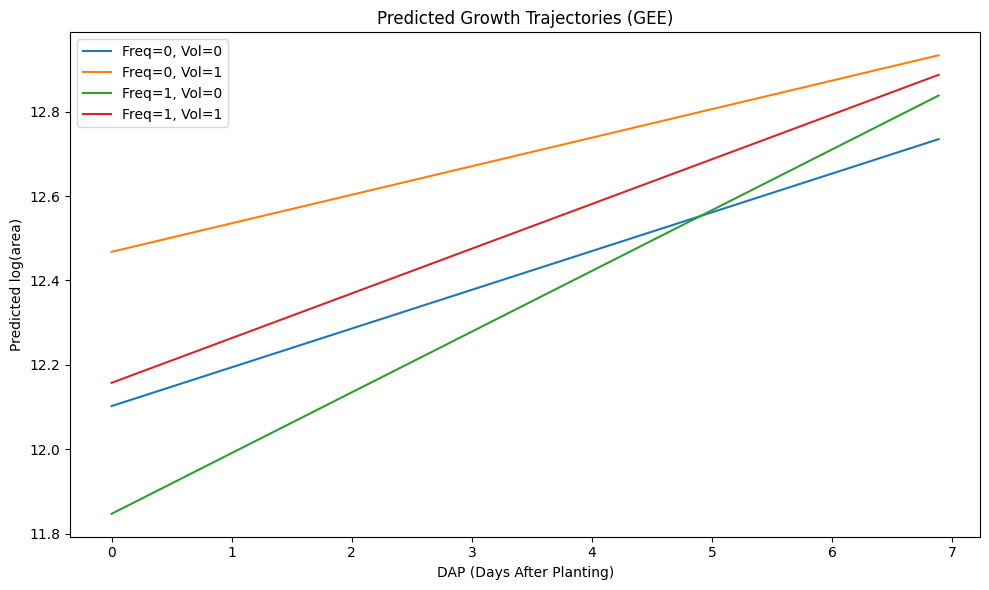

In [34]:
from statsmodels.stats.outliers_influence import summary_table
# Create prediction grid
dap_grid = np.linspace(df_filtered["DAP"].min(), df_filtered["DAP"].max(), 200)
freq_levels = sorted(df_filtered["irrigation_frequency"].unique())
vol_levels  = sorted(df_filtered["irrigation_volume"].unique())

pred_df = pd.DataFrame([
    {"DAP": d, "irrigation_frequency": f, "irrigation_volume": v}
    for d in dap_grid
    for f in freq_levels
    for v in vol_levels
])

pred_df["irrigation_frequency"] = pred_df["irrigation_frequency"].astype("category")
pred_df["irrigation_volume"] = pred_df["irrigation_volume"].astype("category")

pred = result.predict(pred_df)
pred_df["log_area_pred"] = pred

plt.figure(figsize=(10, 6))

for f in freq_levels:
    for v in vol_levels:
        subset = pred_df[
            (pred_df["irrigation_frequency"] == f) &
            (pred_df["irrigation_volume"] == v)
        ]
        label = f"Freq={f}, Vol={v}"
        plt.plot(subset["DAP"], subset["log_area_pred"], label=label)

plt.xlabel("DAP (Days After Planting)")
plt.ylabel("Predicted log(area)")
plt.title("Predicted Growth Trajectories (GEE)")
plt.legend()
plt.tight_layout()
plt.show()




/tmp/ipykernel_1244/3504407431.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


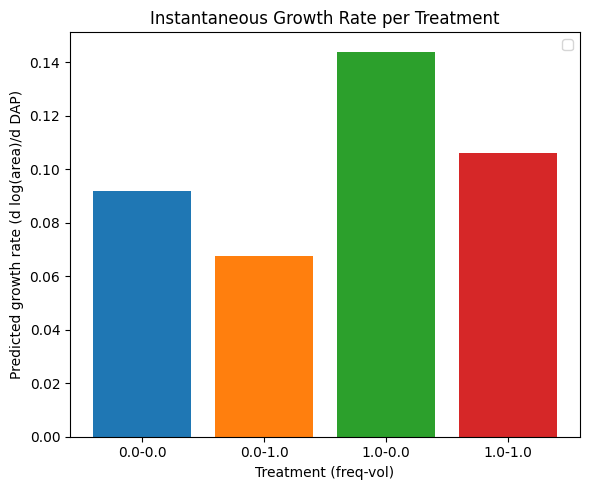

In [ ]:
params = result.params

slopes = []
for f in freq_levels:
    for v in vol_levels:
        slope = params["DAP"]

        if f == 1:
            slope += params["DAP:C(irrigation_frequency)[T.1]"]
        if v == 1:
            slope += params["DAP:C(irrigation_volume)[T.1]"]
        if (f == 1) and (v == 1):
            slope += params["DAP:C(irrigation_frequency)[T.1]:C(irrigation_volume)[T.1]"]

        slopes.append({"freq": f, "vol": v, "slope": slope})

slope_df = pd.DataFrame(slopes)

plt.figure(figsize=(6, 5))
for idx, row in slope_df.iterrows():
    plt.bar(f"{row['freq']}-{row['vol']}", row['slope'])

plt.ylabel("Predicted growth rate (d log(area)/d DAP)")
plt.xlabel("Treatment (freq-vol)")
plt.title("Instantaneous Growth Rate per Treatment")
plt.tight_layout()
plt.show()

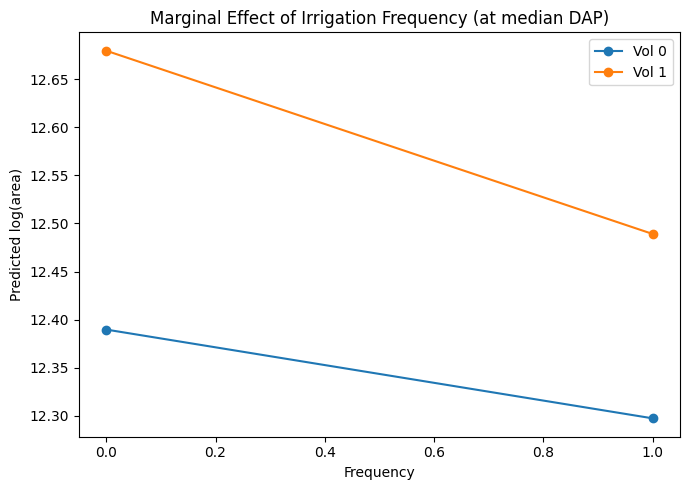

In [36]:
median_dap = df_filtered["DAP"].median()

me_freq = pd.DataFrame({
    "DAP": median_dap,
    "irrigation_volume": vol_levels * len(freq_levels),
    "irrigation_frequency": np.repeat(freq_levels, len(vol_levels))
})

me_freq["irrigation_frequency"] = me_freq["irrigation_frequency"].astype("category")
me_freq["irrigation_volume"] = me_freq["irrigation_volume"].astype("category")

me_freq["pred"] = result.predict(me_freq)

plt.figure(figsize=(7, 5))
for v in vol_levels:
    subset = me_freq[me_freq["irrigation_volume"] == v]
    plt.plot(subset["irrigation_frequency"], subset["pred"], marker="o", label=f"Vol {v}")

plt.title("Marginal Effect of Irrigation Frequency (at median DAP)")
plt.ylabel("Predicted log(area)")
plt.xlabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipykernel_1244/2784662678.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = heat_df.pivot_table(
/tmp/ipykernel_1244/2784662678.py:10: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(pivot, cmap="viridis", origin="lower")
/tmp/ipykernel_1244/2784662678.py:10: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(pivot, cmap="viridis", origin="lower")


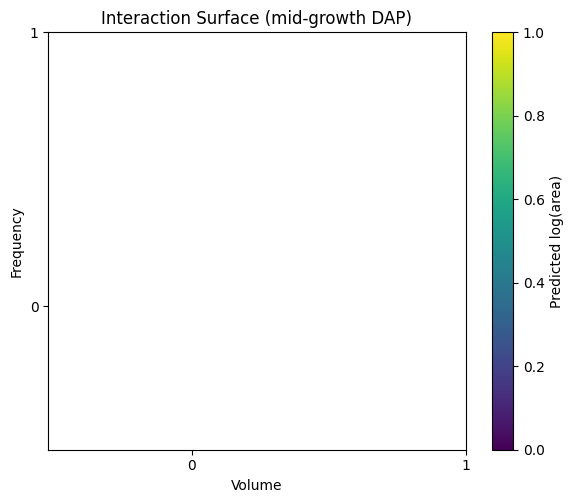

In [37]:
heat_df = pred_df[pred_df["DAP"] == median_dap].copy()

pivot = heat_df.pivot_table(
    index="irrigation_frequency",
    columns="irrigation_volume",
    values="log_area_pred"
)

plt.figure(figsize=(6, 5))
plt.imshow(pivot, cmap="viridis", origin="lower")
plt.colorbar(label="Predicted log(area)")

plt.xticks(range(len(vol_levels)), vol_levels)
plt.yticks(range(len(freq_levels)), freq_levels)

plt.xlabel("Volume")
plt.ylabel("Frequency")
plt.title("Interaction Surface (mid-growth DAP)")
plt.tight_layout()
plt.show()

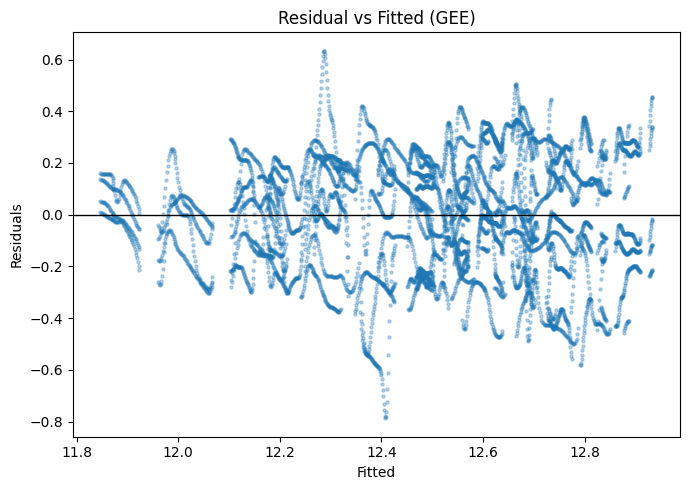

<Figure size 700x300 with 0 Axes>

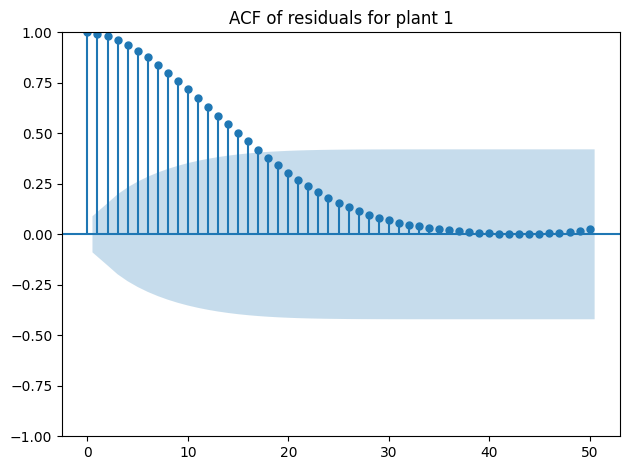

In [ ]:
df_filtered["fitted"] = result.fittedvalues
df_filtered["resid"] = df_filtered["log_area"] - df_filtered["fitted"]

plt.figure(figsize=(7, 5))
plt.scatter(df_filtered["fitted"], df_filtered["resid"], s=5, alpha=0.3)
plt.axhline(0, color="black", lw=1)
plt.xlabel("Fitted")
plt.ylabel("Residuals")
plt.title("Residual vs Fitted (GEE)")
plt.tight_layout()
plt.show()

from statsmodels.graphics.tsaplots import plot_acf

example_plant = df_filtered["plant_id"].iloc[0]
resid_p = df_filtered[df_filtered["plant_id"] == example_plant]["resid"]

plt.figure(figsize=(7, 3))
🎉 You now have full publication-ready visualization code

These figures cover:

    Growth curves

    Treatment differences

    Marginal effects

    Surface interaction

    Diagnostics

If you want, I can also:
✔ Convert all plots to ggplot-style
✔ Produce publication-ready figure panels (A–E)
✔ Export SVG/PDF versions
✔ Add confidence intervals to the predicted curves

Just tell me which upgrades you want.


plot_acf(resid_p, lags=50)
plt.title(f"ACF of residuals for plant {example_plant}")
plt.tight_layout()
plt.show()